# Lab 3 - Exploring Image Data

### Eric Smith and Jake Carlson

# Make way longer*

## Introduction
For this lab we have choosen the CIFAR-10 image data set. The original data set has 60,000 images. 50,000 of these are training images and 10,000 are test images. The images are 32x32 pixels and contain objects from 10 classes. The classes are listed below.
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

This data set was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton for their paper <i>Learning Multiple Layers of Features from Tiny Images</i>. In this study, the authors use several filters to train their model to learn interesting regularities in the set of images, rather than focus on correlations between nearby pictures.


For this lab, we will use the automobile and truck images.

## Business Understanding

### Motivations
The law treats cars and trucks differently on the road. Trucks often have to stop at weigh stations so their contents can be verified. It would be useful to have a tool that can distinguish between cars and trucks. Once a truck has been identified, a record of the truck and its location can be made so that Customs can make sure the truck is checked at the next weigh station.

### Objectives
We want to be able to accurately predict the object in the picture with 90% accuracy.

## Data Understanding

### Data Attributes
The following is a list of attributes in the data, their data types, and a brief description of the attribute.


## Data Quality

Because we only want to look at automobiles and trucks, we will read the image labels and select all of the images that have these labels assigned to them. We will then convert the images to table data for analysis.

In [2]:
import numpy as np
import pandas as pd

df_labels = pd.read_csv('./data/labels.csv')
df_labels.head()

id       label
0   1        frog
1   2       truck
2   3       truck
3   4        deer
4   5  automobile

In [3]:
df_labels = df_labels[ df_labels.label.isin(['automobile', 'truck']) ]
df_labels.head()

id       label
1    2       truck
2    3       truck
4    5  automobile
5    6  automobile
14  15       truck

In [4]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 49999
Data columns (total 2 columns):
id       10000 non-null int64
label    10000 non-null object
dtypes: int64(1), object(1)
memory usage: 234.4+ KB


We still have 10,000 images in this data set, so we will take a random sample of 500 images from each class. In the future we could adapt this ratio to more closely match the ratio of cars ot trucks on the road.

In [5]:
df_labels = pd.concat([df_labels[df_labels.label == "truck"].sample(n=500),
                      df_labels[df_labels.label == "automobile"].sample(n=500)])
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 49072 to 37183
Data columns (total 2 columns):
id       1000 non-null int64
label    1000 non-null object
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


We will now load all of the images in our sample and save them in a data frame. We will convert all of the images to gray scale to reduce the dimensionality of our data by 66%.

In [6]:
# reading pngs in python:
# https://www.daniweb.com/programming/software-development/threads/253957/converting-an-image-file-png-to-a-bitmap-file
from PIL import Image

# reads a png and returns a list of all pixel values in order r, g, b
def get_img_as_rgb_row(image_path):
    img = Image.open(image_path)
    if len(img.split()) == 4:
        # remove alpha if present
        r, g, b, a = img.split()
        img = Image.merge("RGB", (r, g, b))
    r, g, b = img.split()
    r = list(r.getdata())
    g = list(g.getdata())
    b = list(b.getdata())
    # convert to gray scale
    img_list = [(r[i] * 0.2989 + g[i] * 0.5870 + b[i] * 0.1140) for i in range(len(r))]
    return img_list

# generate column names
cols = ['label']
# for i in ['r', 'g', 'b']:
for i in range(1024):
    cols.append("{}".format(i))

# create df and extract color values for all car and truck images
df = pd.DataFrame(columns=cols, index=range(len(df_labels.id.tolist())))
data_dir = "./data/cifar-10/"
idx = 0
for r in df_labels.iterrows():
    entry = [r[1].label]
    entry.extend(get_img_as_rgb_row("{}{}.png".format(data_dir, r[1].id)))
    df.loc[idx] = entry
    idx += 1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 1025 entries, label to 1023
dtypes: object(1025)
memory usage: 7.8+ MB


In [7]:
df.head()

label        0        1        2        3        4        5        6  \
0  truck  224.081  250.007  245.464  246.877  246.877  246.877  245.877   
1  truck  188.689  190.173  192.657  195.439   198.51  201.466  206.939   
2  truck  105.041  107.041  108.453  110.051  111.464  114.051  115.165   
3  truck  139.192  129.986  122.331  130.982  138.555   140.94  140.332   
4  truck  234.708  233.007  234.007  234.007  234.007  234.007  234.007   

         7        8   ...        1014     1015     1016     1017     1018  \
0  246.649  247.008   ...     214.501  214.501  216.387  217.974  218.088   
1   211.71  213.183   ...     117.816  114.816  114.816  115.816  112.332   
2   114.98  116.567   ...     40.3923  40.8052  37.5605    33.49  34.1201   
3  138.463  138.061   ...     96.4419  92.4423  88.4427  96.9427  98.8994   
4  234.007  234.007   ...     242.746  242.746  242.746  243.632  243.632   

      1019     1020     1021     1022     1023  
0  219.088  219.088    213.8  213.028  195.959  
1  107.148  102.149  99.1489  99.5618   98.263  
2  32.8213  31.8214  31.9354  31.8214  31.8214  
3  83.8561  83.7744  80.7747  79.1878  74.3023  
4  242.746  242.746  242.746  242.746  242.746  

[5 rows x 1025 columns]

Let's take a look at a few of the images.

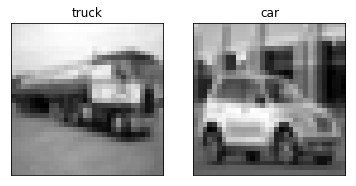

In [8]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 2, figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(df.loc[1, df.columns != 'label'].values.reshape((32,32)).astype(np.float64),
           cmap=plt.cm.gray)
plt.title('truck')
plt.xticks(())
plt.yticks(())
plt.subplot(1, 2, 2)
plt.imshow(df.loc[501, df.columns != 'label'].values.reshape((32,32)).astype(np.float64),
           cmap=plt.cm.gray)
plt.title('car')
plt.xticks(())
plt.yticks(())
plt.show()

We will save this table to disk for easy loading.

In [9]:
df.to_csv('./clean-data/vehicles.csv', sep=',')

### Dimensionality Reduction
After converting to gray scale, our data set has 1,024 dimensions and a label. We want to find a representation for our data in lower dimensional space so it is easier to work with. We will do this using Principle Component Analysis.

First we will read our data from disk.

In [10]:
# start here, remove imports before submitting
import numpy as np
import pandas as pd
df = pd.read_csv('./clean-data/vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 1026 entries, Unnamed: 0 to 1023
dtypes: float64(1024), int64(1), object(1)
memory usage: 7.8+ MB


We will add the column "label int" to our data that we can use as the "target" for our calculations.

For this column, '0' will represent those instances that represent cars (automobiles) and '1' will represent trucks.

In [11]:
from sklearn.decomposition import PCA

# create target_int column: car == 0, truck == 1 
df['label_int'] = [1 if x == 'truck' else 0 for x in df.label]

In [12]:
# manipulated from Sebastian Raschka Example (our book!)
# also from hi blog here: http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
# also from Larson's in class example

def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

We'll begin our analysis by reducing the dimensionality of our data with Principle Component Analysis.

PCA allows us to find which principle components of our data maximize variance and project onto a subspace of lesser dimensionality.

In [13]:
# set X equal to the data portion of df (as a numpy array)
X = df.drop(['label', 'label_int', 'Unnamed: 0'], axis=1, inplace=False) # https://stackoverflow.com/a/37441204
# X = X[[col for col in X if col.startswith('b')]] # select a certain color
X = X.as_matrix()
y = df.label_int.as_matrix()

pca = PCA(n_components = 100)
X_pca = pca.fit(X).transform(X) # fit and transform

print ('pca:', pca.components_) # principle components i.e. eigenvectors
plot_explained_variance(pca)

pca: [[-0.0555369  -0.05621023 -0.05669039 ..., -0.03223316 -0.03287173
  -0.03301839]
 [-0.01944052 -0.01868726 -0.01759765 ...,  0.05937779  0.05789944
   0.05626896]
 [-0.02092864 -0.02039678 -0.02008261 ...,  0.00022308  0.00110313
   0.00076897]
 ..., 
 [-0.01296855 -0.00518622  0.00694942 ...,  0.0036395  -0.00291229
   0.00740723]
 [ 0.02559147  0.01400745  0.00821798 ...,  0.01058531  0.02464975
   0.0359325 ]
 [-0.00384292 -0.00439021 -0.02933965 ..., -0.01686263 -0.01412449
  -0.01113457]]


Above, you can see the components of our data that explain the largest variances in our data. It took 100 dimensions to represent 92% of the variance in our data.



In [14]:
from sklearn.decomposition import KernelPCA

n_components = 100

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=10, # very sensitive to the gamma parameter,
                remove_zero_eig=True)  
X_kpca = kpca.fit_transform(X)

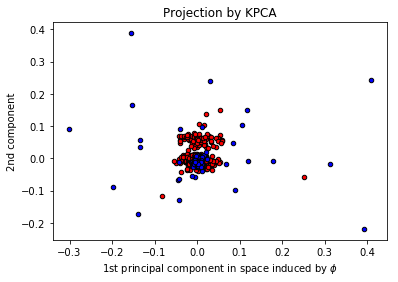

In [15]:
# http://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html
import matplotlib.pyplot as plt

cars = y == 0
trucks = y == 1

# groups = df.groupby('label')

plt.figure()
plt.subplot(1,1,1)
plt.title("Kernel PCA")
plt.scatter(X_kpca[cars, 0], X_kpca[cars, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_kpca[trucks, 0], X_kpca[trucks, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by KPCA")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")
plt.show()

In [16]:
# pca.components_.reshape((n_components, 32, 32))
pca.components_.reshape((n_components, 32, 32))[1].shape
# df.loc[1, df.dtypes == np.float64].values.reshape((32,32)).shape

(32, 32)

In [17]:
# from Prof. Larson's inclass example
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
truck = 1
car = 501

# reconstruct w PCA
low_dimensional_representation, reconstructed_truck_pca = reconstruct_image(pca,X[truck].reshape(1, -1))
low_dimensional_representation, reconstructed_car_pca = reconstruct_image(pca,X[car].reshape(1, -1))

# reconstruct w kPCA
low_dimensional_representation, reconstructed_truck_kpca = reconstruct_image(kpca,X[truck].reshape(1, -1))
low_dimensional_representation, reconstructed_car_kpca = reconstruct_image(kpca,X[car].reshape(1, -1))

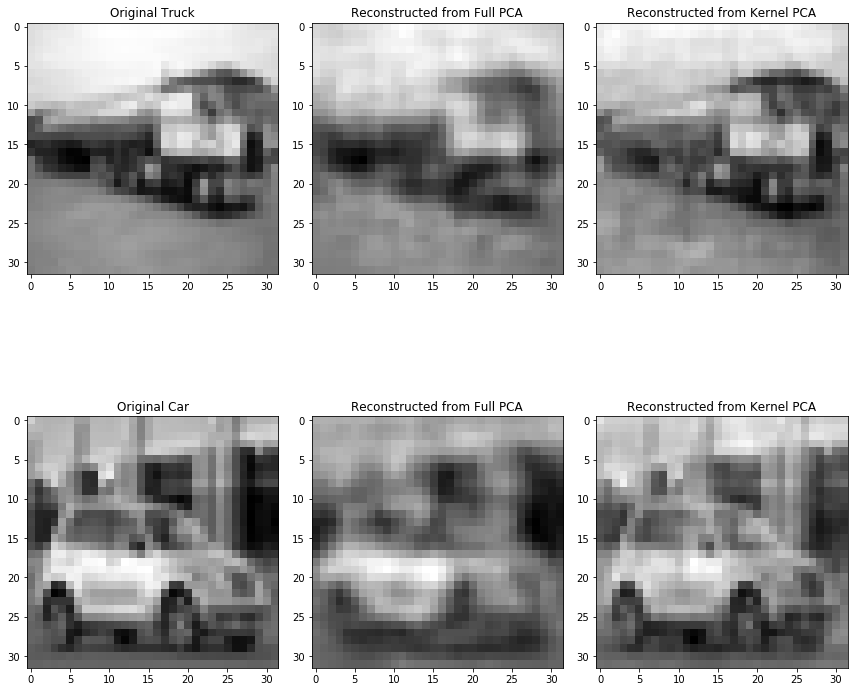

In [18]:
f, ax = plt.subplots(2, 3, figsize=(12, 12))
plt.subplot(2,3,1)
plt.imshow(X[truck].reshape((32, 32)), cmap=plt.cm.gray)
plt.title('Original Truck')

plt.subplot(2,3,2)
plt.imshow(reconstructed_truck_pca.reshape((32, 32)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')

plt.subplot(2,3,3)
plt.imshow(reconstructed_truck_kpca.reshape((32, 32)), cmap=plt.cm.gray)
plt.title('Reconstructed from Kernel PCA')

plt.subplot(2,3,4)
plt.imshow(X[car].reshape((32, 32)), cmap=plt.cm.gray)
plt.title('Original Car')

plt.subplot(2,3,5)
plt.imshow(reconstructed_car_pca.reshape((32, 32)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')

plt.subplot(2,3,6)
plt.imshow(reconstructed_car_kpca.reshape((32, 32)), cmap=plt.cm.gray)
plt.title('Reconstructed from Kernel PCA')

plt.tight_layout(pad=1, w_pad=1, h_pad=1)
plt.show()

After using kernel PCA as our non-linear dimensionality reduction, we reconstructed our car and truck images from both versions of PCA (shown above).

Looking at the resulting pictures, kernel PCA was much better at reconstructing the original. This means that the directions of maximum variance in our data are better expressed along nonlinear space.

Some images, however, may not be perfectly represented by kernel PCA.

In [19]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets  # make this interactive!
# compare the different methods

def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct].reshape(1, -1)))
#    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(X[idx_to_reconstruct].reshape(1, -1)))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct].reshape(1, -1)))
    
    
    plt.figure(figsize=(32,32))
    
    h = 32
    w = 32
    
    plt.subplot(1,3,1)
    plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    plt.grid()
    
    plt.subplot(1,3,2)
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid()

    plt.subplot(1,3,3)
    plt.imshow(reconstructed_image_kpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    plt.grid()
    plt.show()
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,1000-1,1),__manual=True)

<function __main__.plt_reconstruct>

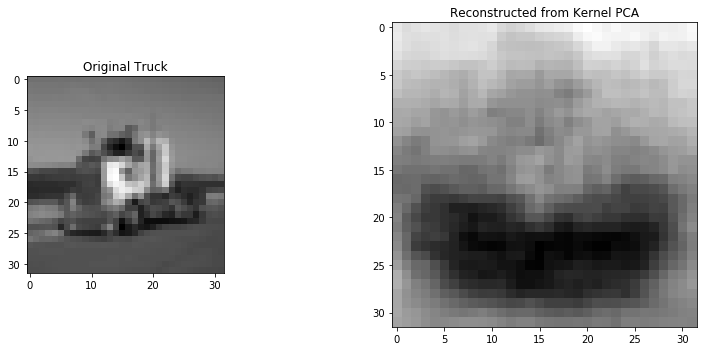

In [20]:
# 50
bad_truck = 50
low_dimensional_representation, reconstructed_truck_pca_bad = reconstruct_image(pca,X[bad_truck].reshape(1, -1))
low_dimensional_representation, reconstructed_truck_kpca_bad = reconstruct_image(kpca,X[bad_truck].reshape(1, -1))

f, ax = plt.subplots(1, 3, figsize=(12, 12))
plt.subplot(1,3,1)
plt.imshow(X[bad_truck].reshape((32, 32)), cmap=plt.cm.gray)
plt.title('Original Truck')

plt.subplot(1,2,2)
plt.imshow(reconstructed_truck_kpca_bad.reshape((32, 32)), cmap=plt.cm.gray)
plt.title('Reconstructed from Kernel PCA')

plt.show()

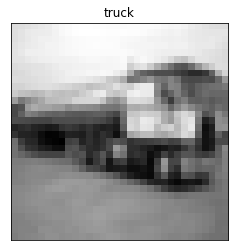

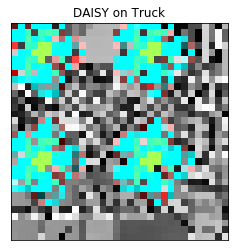

In [21]:
from skimage.feature import daisy

def prep_image_show(img, title):
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

image = df.loc[1, df.dtypes == np.float64].values.reshape((32,32)).astype(np.float64)
prep_image_show(image, 'truck')
plt.show()

features, img_desc = daisy(image, step=16, radius=4, rings=3, histograms=5,
                           orientations=8, visualize=True)
# print(features.shape)
prep_image_show(img_desc, 'DAISY on Truck')
plt.show()

In [22]:
# using apply daisy function from notebook 04. Dimension Reduction and Images
def apply_daisy(img, shape):
    feat = daisy(img.reshape(shape), step=2, radius=8, rings=2, histograms=6,
                 orientations=8, visualize=False)
    return feat.reshape((-1))

just_images = df.drop(['label', 'label_int', 'Unnamed: 0'], axis=1,
                      inplace=False)
just_images = just_images.as_matrix()
%time test_feat = apply_daisy(just_images[1], (32,32))
test_feat.shape

CPU times: user 4.75 ms, sys: 1.25 ms, total: 6.01 ms
Wall time: 5 ms


(6656,)

In [23]:
%time daisy_feats = np.apply_along_axis(apply_daisy, 1, just_images, (32,32))
print(daisy_feats.shape)

CPU times: user 2.84 s, sys: 68.6 ms, total: 2.91 s
Wall time: 3.04 s
(1000, 6656)


In [24]:
from sklearn.metrics.pairwise import pairwise_distances
%time dist_matrix = pairwise_distances(daisy_feats)

CPU times: user 205 ms, sys: 4.54 ms, total: 210 ms
Wall time: 112 ms


/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



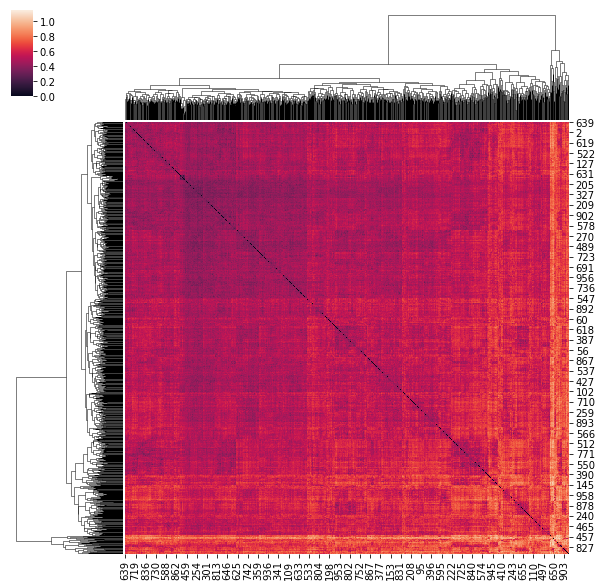

In [25]:
import seaborn as sns

sns.clustermap(dist_matrix)
plt.show()

Maybe the lower right corner are similar car features?

In [26]:
# using the closest image slider
import copy
from ipywidgets import fixed, widgets
# put it together inside a nice widget
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    prep_image_show(X[idx1].reshape((32,32)), "Original Image")

    plt.subplot(1,3,2)
    prep_image_show(X[idx2].reshape((32,32)), "Closest Image")
    
    plt.subplot(1,3,3)
    prep_image_show(X[idx3].reshape((32,32)), "Next Closest Image")
    plt.show()
    
widgets.interact(closest_image,idx1=(0,1000-1,1),dmat=fixed(dist_matrix),__manual=True)

<function __main__.closest_image>

In [186]:
import sys
from collections import Counter

# distances of all images to all images
df_dist = pd.DataFrame(dist_matrix)

# divide df_dist by label comparisons
dist_truck_truck = df_dist[:500].ix[:,:499] # truck v truck
dist_truck_car = df_dist[:500].ix[:,500:] # truck v car
dist_car_car = df_dist[500:].ix[:,500:] # car v car

# labels correspond to buckets of distances
labels = np.array(['< .25', '> .25 < .5', '> .5 < .75', '> .75 < 1', '> 1'])

# prepare the distance data: 
# remove unncessary or duplicate values,
# place into buckets, return the count in each bucket
def get_all_distances(dist):
    dist = np.tril(dist, k=-1) # convert to lower triangular
    dist = dist.flatten() # make one dimensional
    dist = dist[np.nonzero(dist)] # remove all zeroes
    
    # put the distances into different buckets
    dist = pd.cut(dist, 
                    bins=[0, .25, .5, .75, 1, sys.maxsize], 
                    labels=False)
    
    # apply labels, convert to counter
    dist = Counter(sorted(labels[dist])) 
    
    # convert to dataframe
    dist = pd.DataFrame(list(dist.items()), columns=['Distance', 'Count'])
    
    return dist

dist_truck_truck_counts = get_all_distances(dist_truck_truck)
dist_truck_car_counts = get_all_distances(dist_truck_car)
dist_car_car_counts = get_all_distances(dist_car_car)

In [201]:
# group the different diff categories

keys = ['Truck v Truck', 'Truck v Car', 'Car v Car']
dist_lists = [dist_truck_truck_counts, dist_truck_car_counts, dist_car_car_counts]

grouped_dist = pd.DataFrame(columns=['Distance','Type','Count'])

# for each diff category
for i in range(len(dist_lists)):
    temp_list = []
    
    # append all values to the new data frame in a new order
    for j in range(len(dist_lists[i])):
        temp_list.append({'Distance' : dist_lists[i].Distance[j],
                    'Type' : keys[i],
                    'Count' : dist_lists[i].Count[j]})

    grouped_dist = grouped_dist.append(temp_list)

# group by Distance, then Type
grouped_dist = grouped_dist.groupby(['Type', 'Distance']).sum()

grouped_dist  

Count
Type          Distance         
Car v Car     < .25          33
              > .25 < .5  43198
              > .5 < .75  76755
              > .75 < 1    4715
              > 1            49
Truck v Car   > .25 < .5  38968
              > .5 < .75  80549
              > .75 < 1    5201
              > 1            32
Truck v Truck < .25           1
              > .25 < .5  44534
              > .5 < .75  75132
              > .75 < 1    5056
              > 1            27

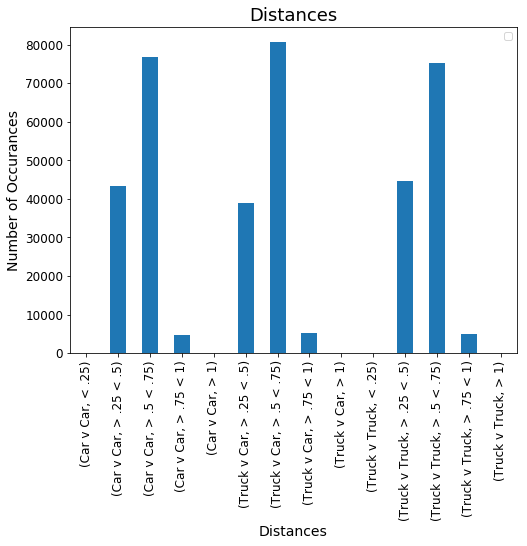

In [202]:
grouped_dist.plot(kind='bar', fontsize=12, figsize=(8,6))


plt.ylabel('Number of Occurances', fontsize=14)
plt.xlabel('Distances', fontsize=14)
plt.title('Distances', fontsize=18)
plt.legend([])
plt.show()

In [ ]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(X))

gabr_feature = compute_gabor(X[idx_to_reconstruct], kernels, (32,32))
gabr_feature

In [ ]:
# takes ~30 seconds to run entire dataset
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, X, kernels, (32,32))
print(gabor_stats.shape)

In [ ]:
# find the pairwise distance between all the different image features
%time dist_matrix_gabor = pairwise_distances(gabor_stats)

In [ ]:
widgets.interact(closest_image,idx1=(0,1000-1,1),dmat=fixed(dist_matrix_gabor),__manual=True)

## References
Alex Krizhevsky, 2009: <a href="http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf">Learning Multiple Layers of Features from Tiny Images</a>